In [640]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer


from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from functools import partial



pd.options.display.max_rows = None  # Show all rows
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_colwidth = None  # Ensure full content is visible
pd.set_option('display.float_format', '{:.6f}'.format)  # Adjust decimal places as needed

In [641]:
cdc2023 = pd.read_csv(r"data_files\CDC_2023.csv")

In [642]:
# Obtaining features with missing values above 80%
nan_percent = 100 * cdc2023.isnull().sum() / len(cdc2023)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent[nan_percent > 80]

WKENDOUT   100.000000
WKDAYOUT   100.000000
SUNPRTCT   100.000000
NUMBURN3   100.000000
INDORTAN   100.000000
COLGHOUS    99.997231
LASTSIG4    99.966307
LNDSXBRT    99.960999
CSRVCTL2    99.948768
VCLNTES2    99.921537
SDNATES1    99.882074
BLDSTFIT    99.881843
CRVCLHPV    99.865458
CRVCLCNC    99.864997
CRVCLPAP    99.864997
HOWLONG     99.789072
HADHYST2    99.750071
CERVSCRN    99.748686
HADMAM      99.747763
SIGMTES1    99.717070
CCLGHOUS    99.688223
CSRVINST    99.686146
CSRVCLIN    99.585759
CSRVDEIN    99.585298
CSRVINSR    99.584836
CSRVRTRN    99.583452
CSRVSUM     99.582990
CSRVDOC1    99.582759
LCSCTWHN    99.547682
STOLTEST    99.501296
HPVADSHT    99.471064
CELSXBRT    99.405063
STOOLDN2    99.402986
SMALSTOL    99.401140
VIRCOLO1    99.400447
RCSXBRTH    99.392139
CSRVPAIN    99.360062
CSRVTRT3    99.152826
IMFVPLA4    99.062362
CASTHNO2    98.904051
USEMRJN4    98.902897
LCSLAST     98.442732
NUMPHON4    98.307037
COLNTES1    98.280959
COLNSIGM    98.232958
LCSNUMCG  

In [643]:
features_over_80_missing = nan_percent[nan_percent > 80].index.tolist()

# Dropping Specified Columns
cdc2023.drop(columns=features_over_80_missing, axis=1, inplace=True)

In [644]:
len(cdc2023.columns)

209

In [645]:
features = sorted(cdc2023.columns)
features

['ACTIN13_',
 'ACTIN23_',
 'ADDEPEV3',
 'ALCDAY4',
 'ASTHMA3',
 'AVEDRNK3',
 'BIRTHSEX',
 'BLIND',
 'BPHIGH6',
 'BPMEDS1',
 'CADULT1',
 'CELLFON5',
 'CELLSEX2',
 'CELPHON1',
 'CHCCOPD3',
 'CHCKDNY2',
 'CHCOCNC1',
 'CHCSCNC1',
 'CHECKUP1',
 'CHILDREN',
 'CHOLCHK3',
 'CHOLMED3',
 'CIMEMLO1',
 'COVIDNU2',
 'COVIDPO1',
 'COVIDSM1',
 'COVIDVA1',
 'CPDEMO1C',
 'CSTATE1',
 'CTELENM1',
 'CTELNUM1',
 'CVDCRHD4',
 'CVDINFR4',
 'CVDSTRK3',
 'DEAF',
 'DECIDE',
 'DIABETE4',
 'DIFFALON',
 'DIFFDRES',
 'DIFFWALK',
 'DISPCODE',
 'DRNK3GE5',
 'DRNKANY6',
 'DRNKDRI2',
 'DROCDY4_',
 'ECIGNOW2',
 'EDUCA',
 'EMPLOY1',
 'EMTSUPRT',
 'EXERANY2',
 'EXERHMM1',
 'EXERHMM2',
 'EXEROFT1',
 'EXEROFT2',
 'EXRACT12',
 'EXRACT22',
 'FALL12MN',
 'FC601_',
 'FLSHTMY3',
 'FLUSHOT7',
 'FMONTH',
 'FOODSTMP',
 'GENHLTH',
 'HAVARTH4',
 'HEATTBCO',
 'HEIGHT3',
 'HHADULT',
 'HIVTST7',
 'HIVTSTD3',
 'HTIN4',
 'HTM4',
 'IDATE',
 'IDAY',
 'IMONTH',
 'INCOME3',
 'IYEAR',
 'LADULT1',
 'LANDLINE',
 'LSATISFY',
 'MARIJAN1',
 'MARITA

In [646]:
# These features will be dropped as they have no use or have too much correlation with other features as those features were built off the others. 
# For instance, 'IDATE' is useless as it is just the date the interview occurred in 2023 and '_BMI5' has other features structured better for modelling

additional_features_to_drop = ['CADULT1', 'CELLFON5', 'CELLSEX2', 'CELPHON1', 'CPDEMO1C', 'CSTATE1', 'CTELENM1', 'CTELNUM1', 'DISPCODE', 'FC601_', 'FMONTH', 'HHADULT', 
                               'IDATE', 'IDAY', 'IMONTH', 'IYEAR', 'LADULT1', 'LANDLINE', 'METVL12_', 'NUMADULT', 'NUMHHOL4', 'PAMISS3_', 'PERSDOC3', 'PVTRESD1',
                               'PVTRESD3', 'QSTLANG', 'QSTVER', 'RENTHOM1', 'RRPHYSM2', 'SAFETIME', 'SDHBILLS', 'SDHUTILS', 'SEQNO', 'SOFEMALE', 'SOMALE', 'STATERE1',
                               'TRNSGNDR', 'WEIGHT2', '_AGE65YR', '_AGE_G', '_BMI5', '_CHISPNC', '_DUALCOR', '_DUALUSE', '_HISPANC', '_HLTHPL1', '_LLCPWT',
                                '_LLCPWT2', '_PSU', '_RACEG21', '_RACEGR3', '_RACEPRV', '_RAWRAKE', '_RFBMI5', '_RFSEAT3', '_STRWT', '_STSTR', '_WT2RAKE', 'FLSHTMY3']


# Dropping Specified Columns
cdc2023.drop(columns=additional_features_to_drop, axis=1, inplace=True)

In [647]:
len(cdc2023.columns)

150

In [648]:
features = sorted(cdc2023.columns)

features

['ACTIN13_',
 'ACTIN23_',
 'ADDEPEV3',
 'ALCDAY4',
 'ASTHMA3',
 'AVEDRNK3',
 'BIRTHSEX',
 'BLIND',
 'BPHIGH6',
 'BPMEDS1',
 'CHCCOPD3',
 'CHCKDNY2',
 'CHCOCNC1',
 'CHCSCNC1',
 'CHECKUP1',
 'CHILDREN',
 'CHOLCHK3',
 'CHOLMED3',
 'CIMEMLO1',
 'COVIDNU2',
 'COVIDPO1',
 'COVIDSM1',
 'COVIDVA1',
 'CVDCRHD4',
 'CVDINFR4',
 'CVDSTRK3',
 'DEAF',
 'DECIDE',
 'DIABETE4',
 'DIFFALON',
 'DIFFDRES',
 'DIFFWALK',
 'DRNK3GE5',
 'DRNKANY6',
 'DRNKDRI2',
 'DROCDY4_',
 'ECIGNOW2',
 'EDUCA',
 'EMPLOY1',
 'EMTSUPRT',
 'EXERANY2',
 'EXERHMM1',
 'EXERHMM2',
 'EXEROFT1',
 'EXEROFT2',
 'EXRACT12',
 'EXRACT22',
 'FALL12MN',
 'FLUSHOT7',
 'FOODSTMP',
 'GENHLTH',
 'HAVARTH4',
 'HEATTBCO',
 'HEIGHT3',
 'HIVTST7',
 'HIVTSTD3',
 'HTIN4',
 'HTM4',
 'INCOME3',
 'LSATISFY',
 'MARIJAN1',
 'MARITAL',
 'MAXDRNKS',
 'MAXVO21_',
 'MEDCOST1',
 'MENTHLTH',
 'METVL22_',
 'PA3MIN_',
 'PA3VIGM_',
 'PADUR1_',
 'PADUR2_',
 'PAFREQ1_',
 'PAFREQ2_',
 'PAMIN13_',
 'PAMIN23_',
 'PAVIG13_',
 'PAVIG23_',
 'PDIABTS1',
 'PHYSHLTH',
 'PNE

In [649]:
# These correlations were checked individually for each column together with the codebook
# Compute correlation of 'HEIGHT3' with all other columns
feature_corr = cdc2023.corr()['HEIGHT3'].dropna()

# Filter only correlations with absolute value > 0.50
strong_corr_vol = feature_corr[abs(feature_corr) > 0.50]

# Print correlation values sorted in descending order
print(strong_corr_vol.sort_values(ascending=False, key=abs))

# We choose to drop 'HEIGHT3' as the units are measured in both feet and meters. However, feature 'HTIN4' and 'HTM4' are measured in inches and meters respectively.
# The feature 'HTM4' is kept and the others dropped as it has the least missing values and has a consistent unit measurement in inches.

HEIGHT3   1.000000
HTIN4     0.772537
Name: HEIGHT3, dtype: float64


In [ ]:
# Dropping highly correlated features and purposely leaving features that have the least missing values and structured appropriately to reduce the need for transformations and cleaning 
correlated_features_to_drop = ['DRNKDRI2', 'ALCDAY4', '_ASTHMS1', 'AVEDRNK3', '_DRNKWK2', 'BIRTHSEX', '_SEX', '_CHOLCH3', '_MICHD', 'DRNK3GE5',
                               '_DRNKWK2', 'DROCDY4_', '_EDUCAG', '_TOTINDA', 'PAMIN13_', '_MINAC12', 'EXERHMM1', 'EXERHMM2', '_MINAC22', 'PAMIN23_',
                                'EXEROFT2', 'EXRACT22', 'FALL12MN', '_FLSHOT7', '_RFHLTH', '_DRDXAR2', 'HEIGHT3', '_AIDTST4', 'HIVTSTD3', 'HTIN4',
                                '_INCOMG1', 'MAXDRNKS', 'METVL22_', 'PA3MIN_', 'PAVIG23_', 'PAMIN23_', 'PADUR2_', 'PAFREQ2_', 'PAVIG23_', '_PNEUMO3',
                                'RRCLASS3', 'RRCOGNT2', 'RRHCARE4', 'SDHTRNSP', '_RFSEAT2', 'SMOKDAY2', '_RFSMOK3', 'SMOKE100', 'STRENGTH', '_AGE80',
                                '_HCVU653', '_CASTHM1', '_MENT14D', '_METSTAT', '_PA30023', '_PA150R4', '_PASTAE3', '_PAINDX3', '_PASTRNG', '_PHYS14D',
                                '_RACE', '_RFBING6', '_RFCHOL3', 'PAFREQ1_', 'PA3VIGM_', 'PAVIG13_', 'LSATISFY', 'RRTREAT', 'PDIABTS1', 'CIMEMLO1',
                                'MARIJAN1']

# Dropping Specified Columns
cdc2023.drop(columns=correlated_features_to_drop, axis=1, inplace=True)

In [651]:
len(cdc2023.columns)

85

In [652]:
# Obtaining features with missing values above 80%
nan_percent = 100 * cdc2023.isnull().sum() / len(cdc2023)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent

MARIJAN1   79.550359
COVIDNU2   74.440775
COVIDVA1   69.561736
CIMEMLO1   68.635637
PREDIAB2   61.656316
PDIABTS1   61.633931
BPMEDS1    59.332415
COVIDSM1   53.610355
SDHSTRE1   48.423462
ACTIN23_   48.055838
SDHFOOD1   48.045915
FOODSTMP   47.966067
SDHEMPLY   47.905142
SDLONELY   47.845372
EMTSUPRT   47.771524
HEATTBCO   45.095460
POORHLTH   41.805535
SHINGLE2   40.783665
PADUR1_    27.158725
ACTIN13_   26.748176
EXEROFT1   25.450299
EXRACT12   24.945826
CHOLMED3   12.332602
TOLDHI3    11.956901
_BMI5CAT    9.354454
WTKG3       7.881188
COVIDPO1    7.388253
SEATBELT    7.102785
HIVTST7     6.833932
PNEUVAC4    6.634774
FLUSHOT7    6.404230
HTM4        5.109583
ECIGNOW2    4.954041
USENOW3     4.716343
DIFFALON    4.121637
DIFFDRES    3.892939
DIFFWALK    3.726089
DECIDE      3.493699
STRFREQ_    3.270770
BLIND       3.249308
DEAF        3.017380
_URBSTAT    1.920738
INCOME3     1.863506
CHILDREN    1.175105
EMPLOY1     0.684939
VETERAN3    0.281314
_MRACE1     0.058617
EDUCA       0

In [ ]:
features_to_fill_with_15_percent_less = nan_percent[nan_percent < 15].index.tolist()

In [ ]:
for feature in features_to_fill_with_15_percent_less:
    # As there are only 4 missing values, we can just fill with most frequent without worries
    cdc2023[feature] = cdc2023[feature].fillna(cdc2023[feature].median())

    print(cdc2023[feature].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [639]:
# Obtaining features with missing values above 80%
nan_percent = 100 * cdc2023.isnull().sum() / len(cdc2023)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent

MARIJAN1   79.550359
BIRTHSEX   75.715575
COVIDNU2   74.440775
COVIDVA1   69.561736
HIVTSTD3   69.245805
CIMEMLO1   68.635637
RRHCARE4   67.383915
RRTREAT    67.274758
RRCOGNT2   67.192141
RRCLASS3   67.113447
SMOKDAY2   63.390127
PREDIAB2   61.656316
PDIABTS1   61.633931
_PNEUMO3   60.578368
_FLSHOT7   60.578368
BPMEDS1    59.332415
COVIDSM1   53.610355
MAXDRNKS   51.240530
DRNK3GE5   51.147527
AVEDRNK3   51.046679
DRNKDRI2   50.843828
PAMIN23_   49.752033
PAVIG23_   48.893781
SDHSTRE1   48.423462
PADUR2_    48.413770
SDHTRNSP   48.245074
PAFREQ2_   48.185995
ACTIN23_   48.055838
SDHFOOD1   48.045915
FOODSTMP   47.966067
SDHEMPLY   47.905142
SDLONELY   47.845372
EMTSUPRT   47.771524
LSATISFY   47.688906
METVL22_   47.208664
EXEROFT2   47.208664
EXERHMM2   47.208664
HEATTBCO   45.095460
POORHLTH   41.805535
SHINGLE2   40.783665
FALL12MN   32.499313
PAMIN13_   29.449625
_MINAC22   28.447832
PA3MIN_    28.442755
_MINAC12   28.267828
PAVIG13_   27.851510
PA3VIGM_   27.397576
PADUR1_    27

In [591]:
features_to_fill_with_15_percent_more_60_percent_less = nan_percent[(nan_percent > 15) & (nan_percent < 60)].index.tolist()

features_to_fill_with_15_percent_more_60_percent_less

['BPMEDS1',
 'COVIDSM1',
 'SDHSTRE1',
 'ACTIN23_',
 'SDHFOOD1',
 'FOODSTMP',
 'SDHEMPLY',
 'SDLONELY',
 'EMTSUPRT',
 'HEATTBCO',
 'POORHLTH',
 'SHINGLE2',
 'PADUR1_',
 'ACTIN13_',
 'EXEROFT1',
 'EXRACT12']

In [592]:
possible_features_demographics_to_use = [ 'SEXVAR', '_IMPRACE', 'GENHLTH', 'MARITAL', 'EDUCA', 'CHILDREN', 'INCOME3', '_AGEG5YR', 'EMPLOY1']

demographic_continuous_features = ['WTKG3', 'HTM4']

In [593]:
# Replace special codes: 77, 99 → 0, 
cdc2023['EXRACT12'] = cdc2023['EXRACT12'].replace({77: 12, 99: 12})

# Replace special codes: 77, 88, 99 → 0, 
cdc2023['POORHLTH'] = cdc2023['POORHLTH'].replace({77: 0, 88: 0, 99: 0})

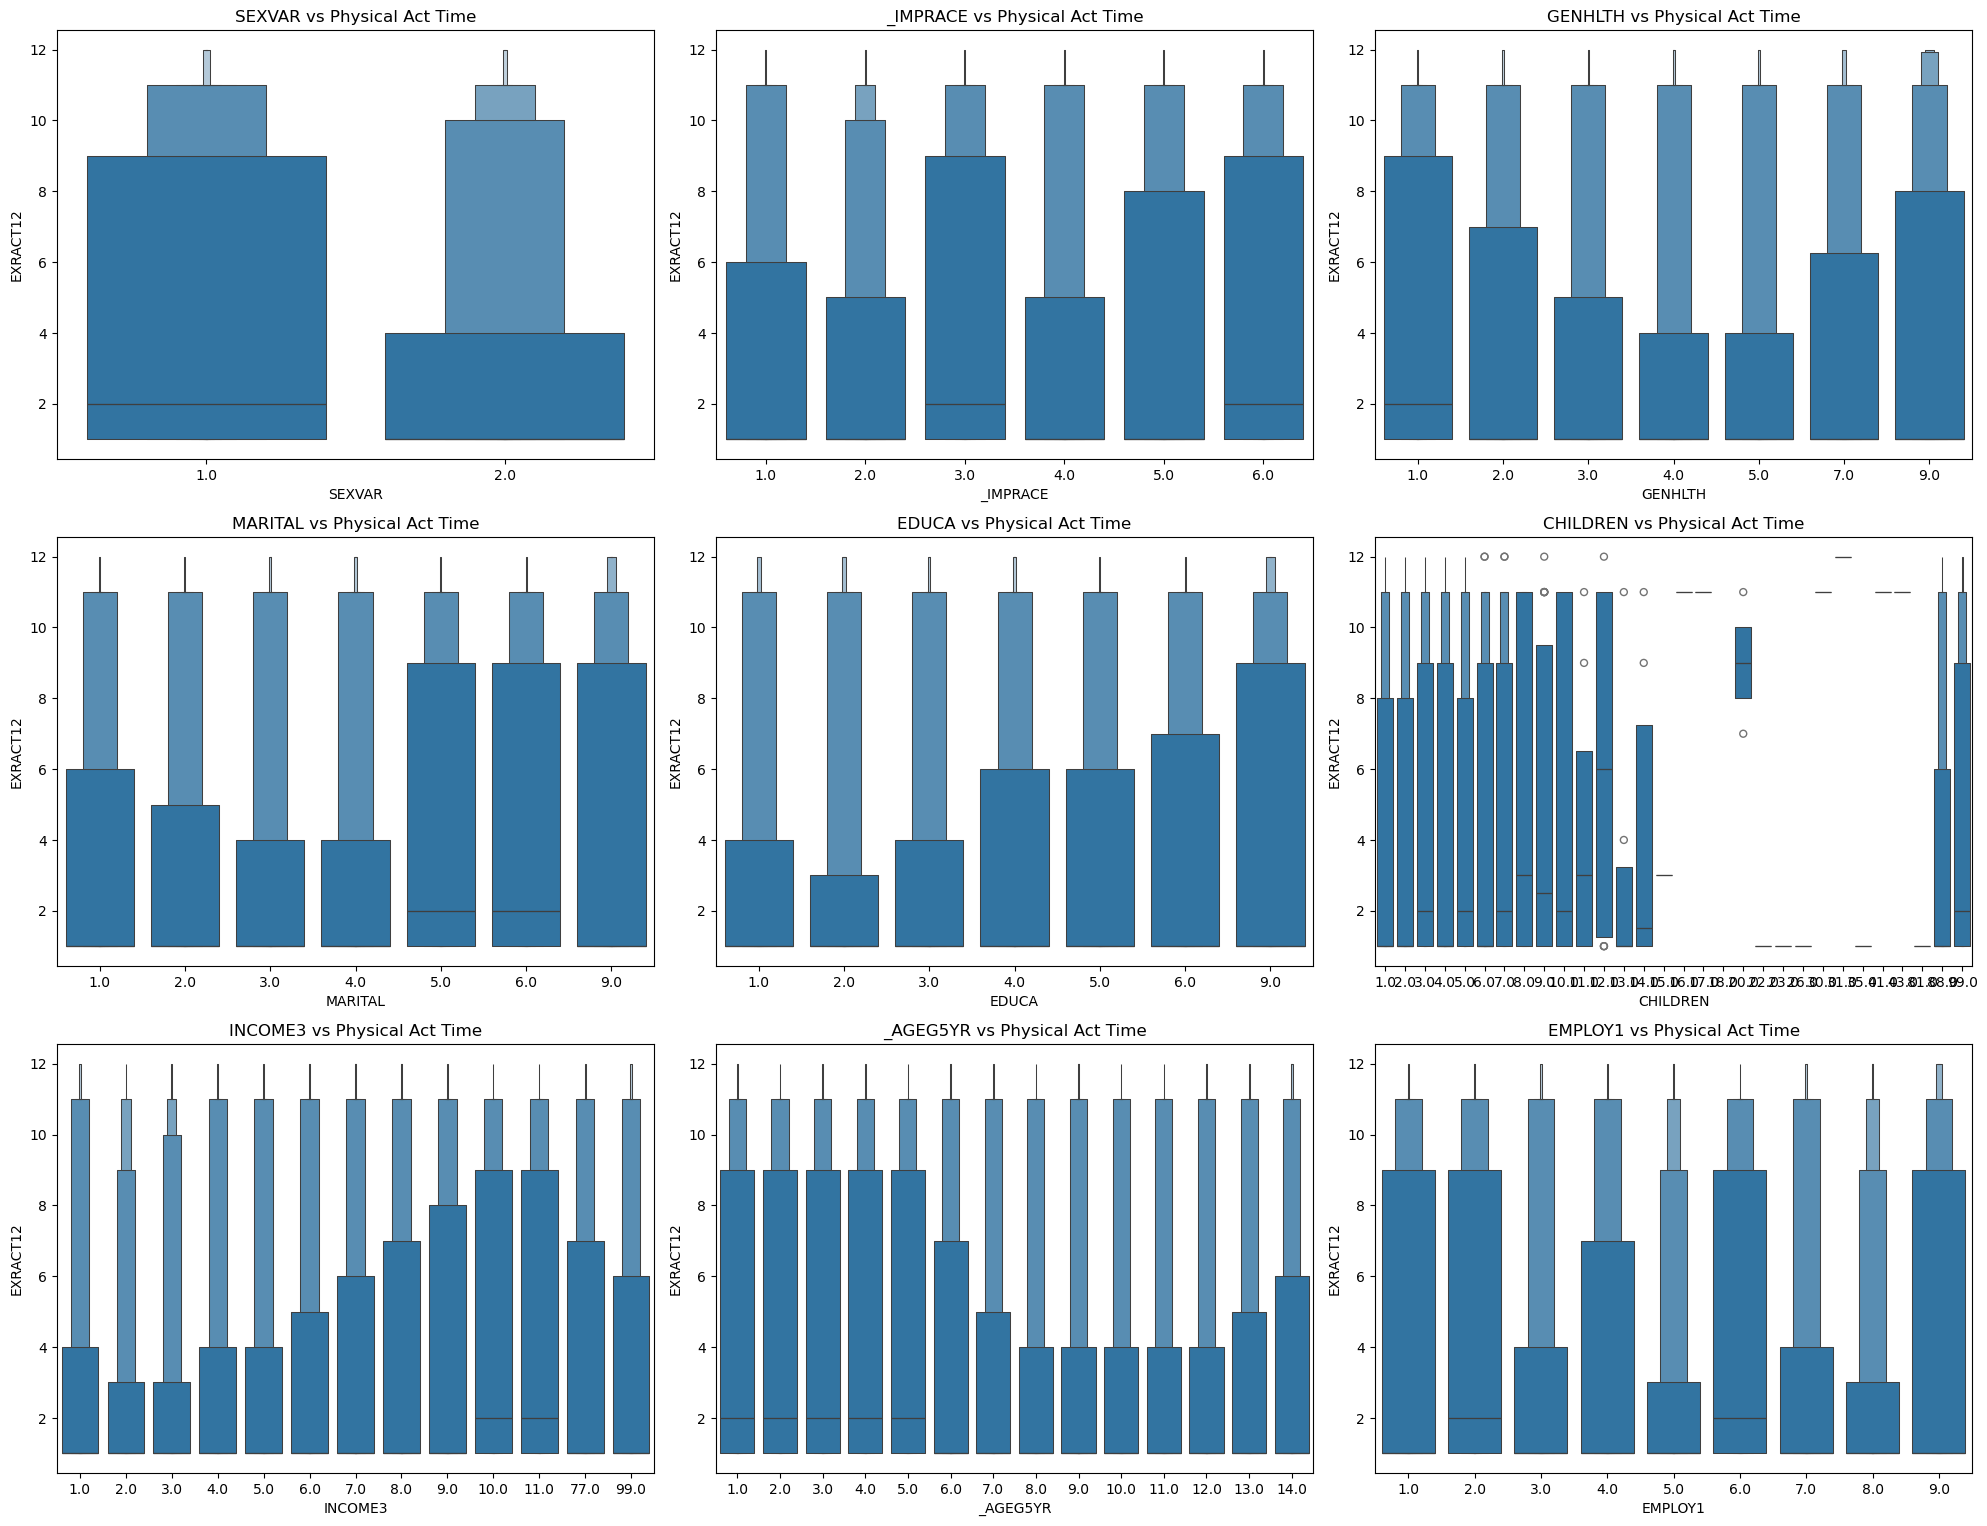

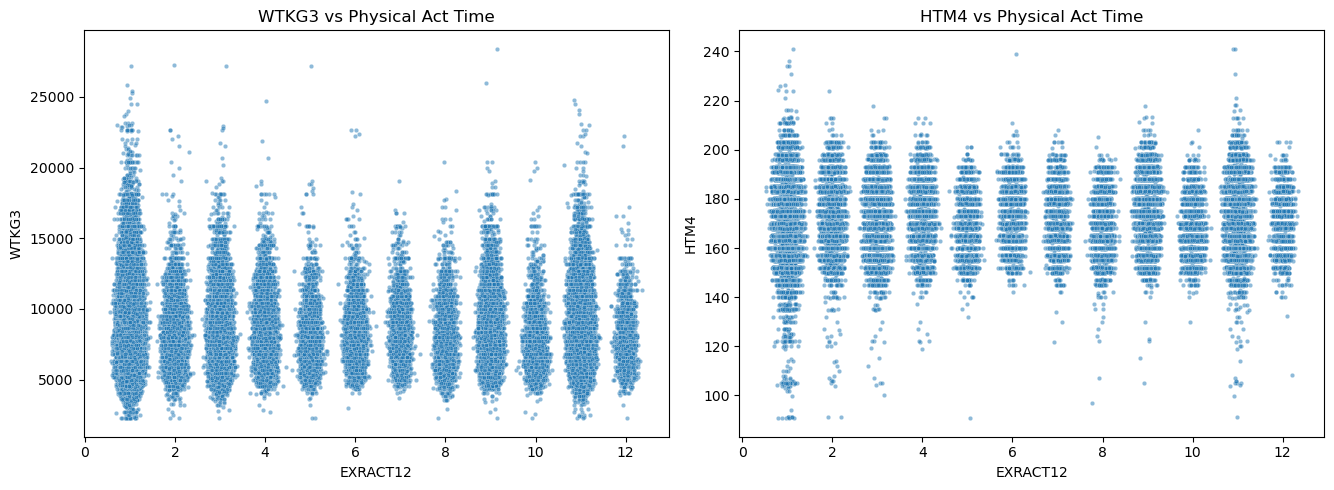

In [594]:
# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(possible_features_demographics_to_use) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(possible_features_demographics_to_use) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(possible_features_demographics_to_use):
    sns.boxenplot(x=cdc2023[col], y =cdc2023['EXRACT12'], ax=axes[i])
    axes[i].set_title(f'{col} vs Physical Act Time')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(possible_features_demographics_to_use), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(demographic_continuous_features) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(demographic_continuous_features) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(demographic_continuous_features):
    x_jittered = cdc2023['EXRACT12'] + np.random.normal(0, 0.1, size=len(cdc2023))
    y_jittered = cdc2023[col] + np.random.normal(0, 0.1, size=len(cdc2023))

    sns.scatterplot(x= x_jittered , y=y_jittered, ax=axes[i], alpha=0.5, s=10)
    axes[i].set_title(f'{col} vs Physical Act Time')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(demographic_continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [595]:
# From the plots above, it can be gender is an important factor for the type of exercises one chooses to do.
# Hence, we would group by the gender of the individual to fill for the mode based on that feature
cdc2023['EXRACT12'] = cdc2023.groupby(['SEXVAR'])['EXRACT12'].transform(lambda value: value.fillna(value.mode().iloc[0]))

cdc2023['EXRACT12'].isnull().sum()

0

In [596]:
# Define a conversion function for alco_days
def convert_alco_days(val):
    if val in [777, 999]:
        return np.nan
    elif 100 <= val < 1000:
        return val % 10
    else:
        return val

# Apply the conversion function to the 'alco_days' column.
cdc2023['EXEROFT1'] = cdc2023['EXEROFT1'].apply(convert_alco_days)

# Calculate the median for alco_days_clean (ignoring missing values)
median_alco_days = cdc2023['EXEROFT1'].median()

# Replace missing values (from codes 777 and 999) with the median
cdc2023['EXEROFT1'] = cdc2023['EXEROFT1'].fillna(median_alco_days)

# Check the results: print unique values and summary statistics.
print("Unique values for number of times of physical activity:")
print(cdc2023['EXEROFT1'].unique())

print("\nSummary statistics for number of times of physical activity:")
print(cdc2023['EXEROFT1'].describe())


Unique values for number of times of physical activity:
[3. 6. 5. 2. 0. 7. 4. 9. 1. 8.]

Summary statistics for number of times of physical activity:
count   433323.000000
mean         3.365720
std          1.931288
min          0.000000
25%          3.000000
50%          3.000000
75%          5.000000
max          9.000000
Name: EXEROFT1, dtype: float64


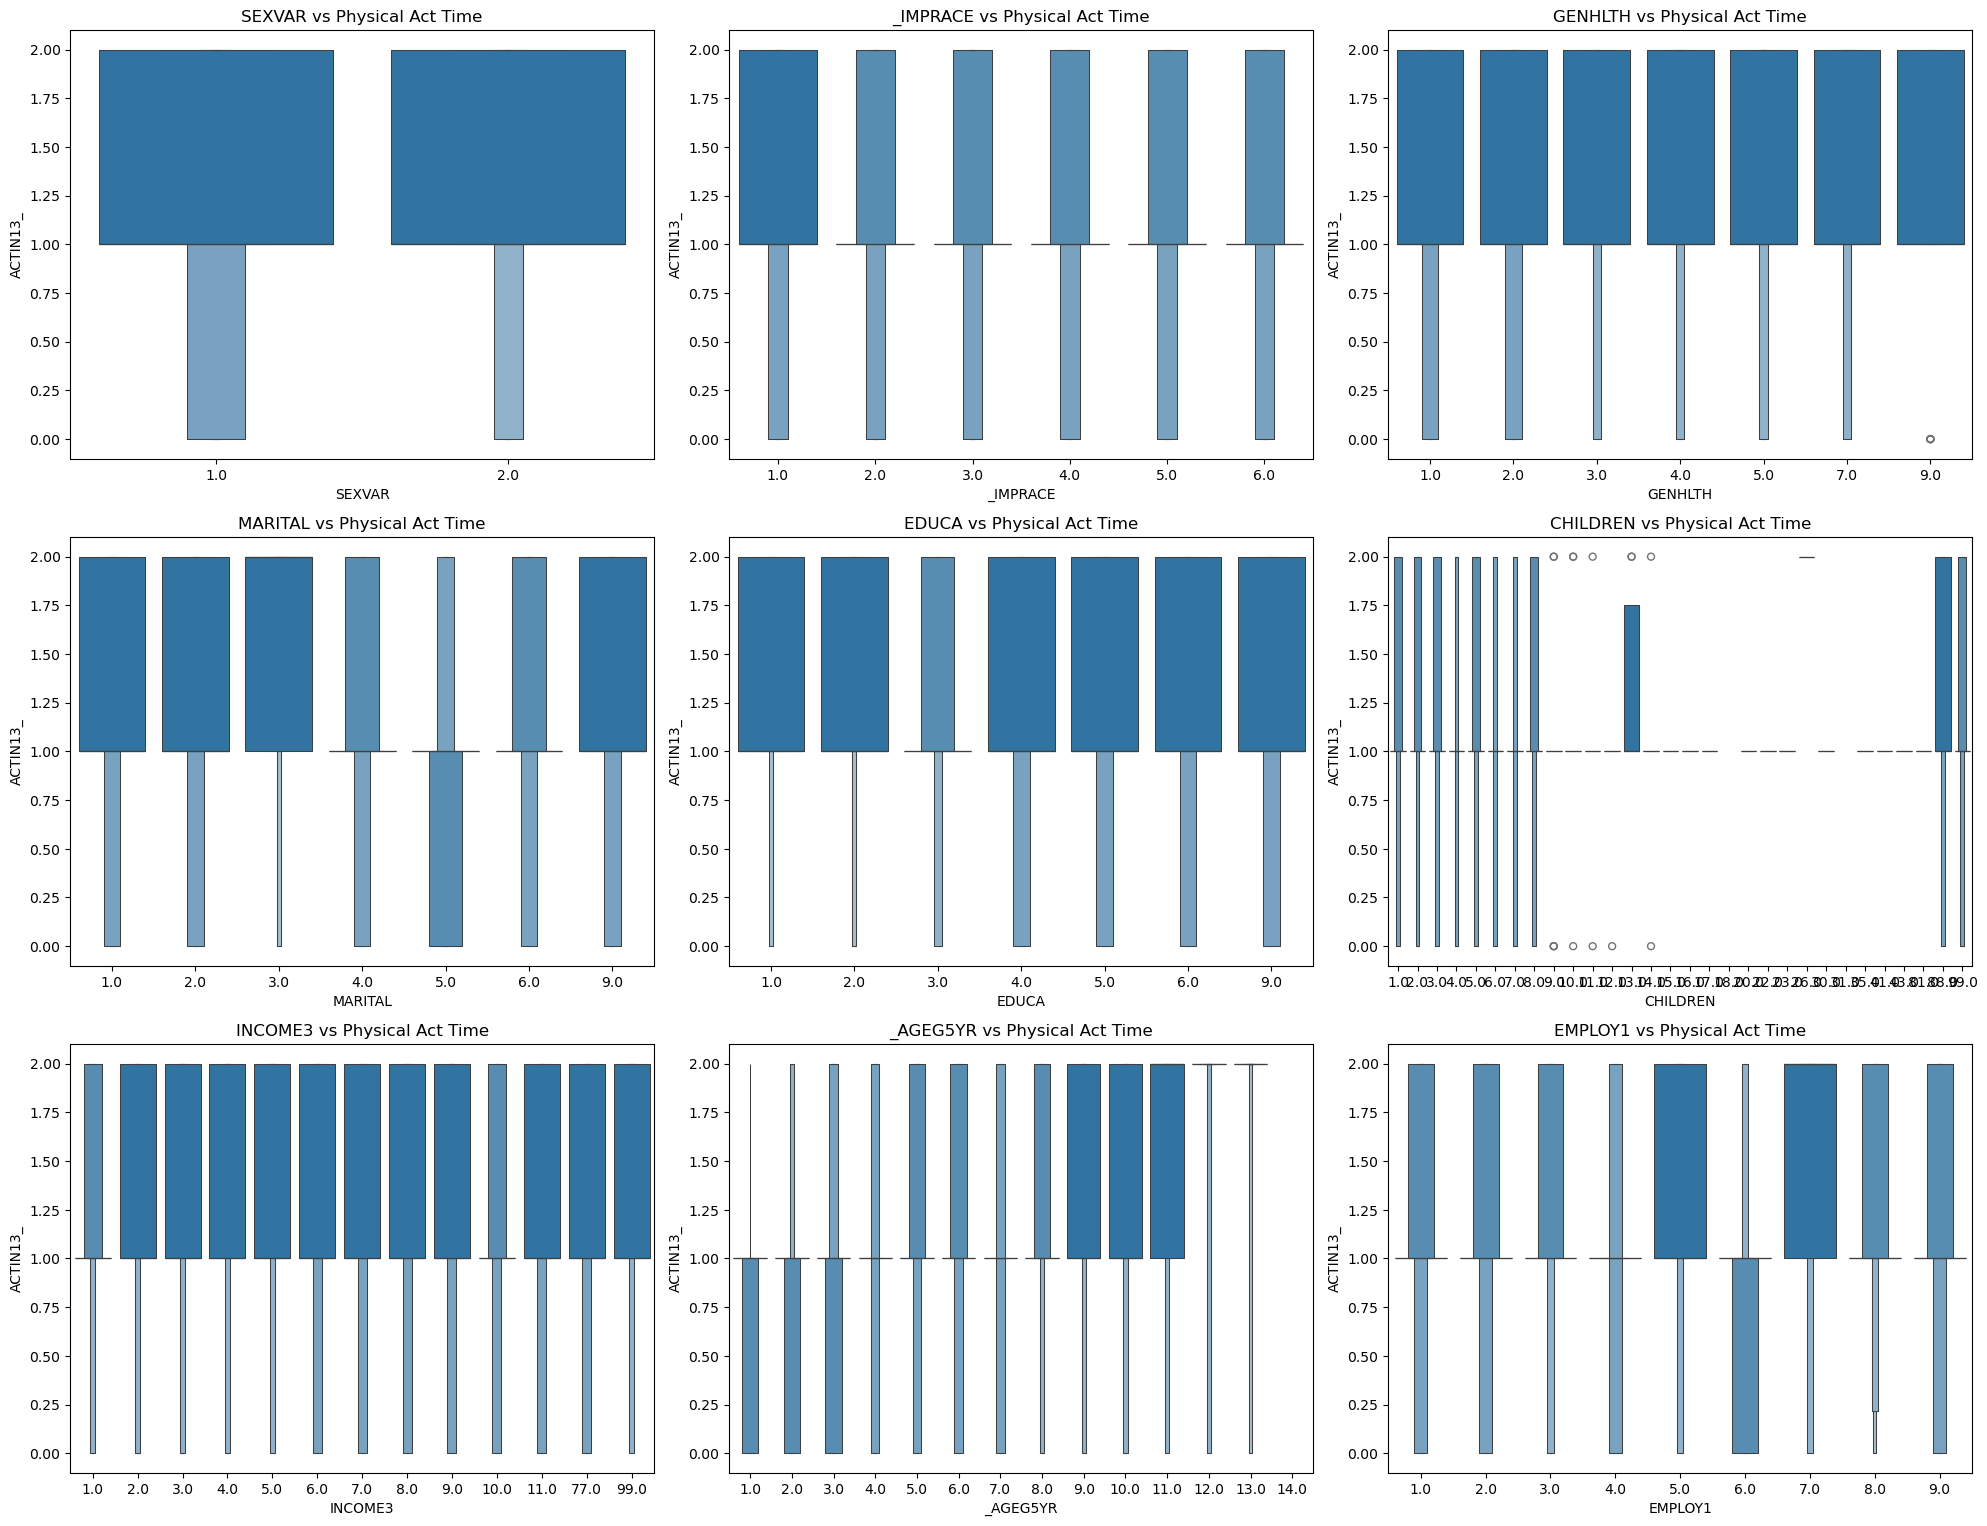

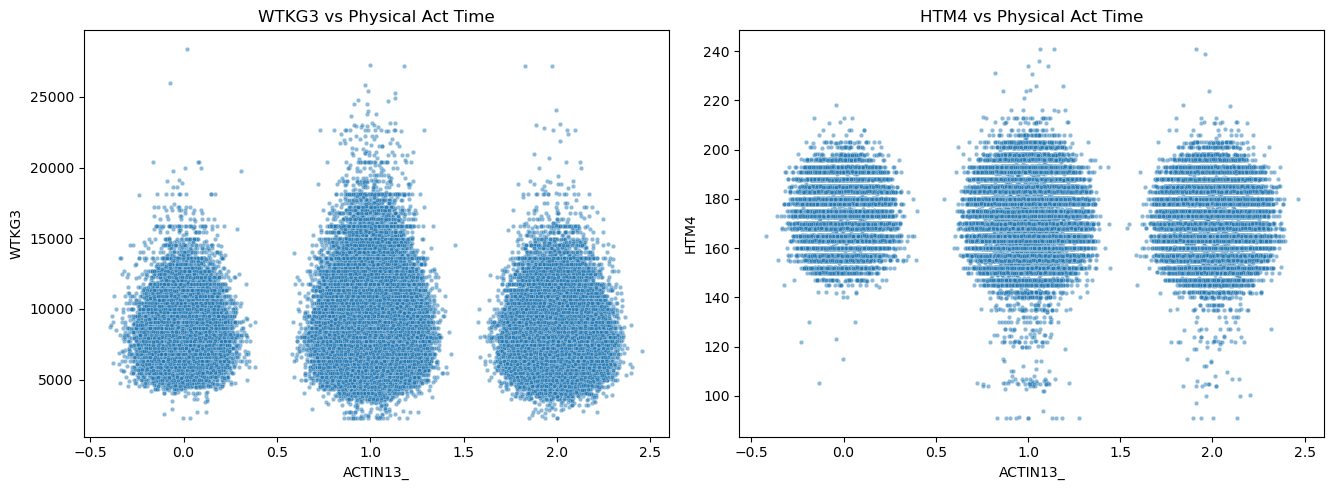

In [597]:
# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(possible_features_demographics_to_use) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(possible_features_demographics_to_use) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(possible_features_demographics_to_use):
    sns.boxenplot(x=cdc2023[col], y =cdc2023['ACTIN13_'], ax=axes[i])
    axes[i].set_title(f'{col} vs Physical Act Time')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(possible_features_demographics_to_use), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(demographic_continuous_features) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(demographic_continuous_features) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(demographic_continuous_features):
    x_jittered = cdc2023['ACTIN13_'] + np.random.normal(0, 0.1, size=len(cdc2023))
    y_jittered = cdc2023[col] + np.random.normal(0, 0.1, size=len(cdc2023))

    sns.scatterplot(x= x_jittered , y=y_jittered, ax=axes[i], alpha=0.5, s=10)
    axes[i].set_title(f'{col} vs Physical Act Time')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(demographic_continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [598]:
# From the plots above, it can be general health is an important factor for the type of exercises one chooses to do.
# Hence, we would group by the general health of the individual to fill for the mode based on that feature
cdc2023['ACTIN13_'] = cdc2023.groupby(['GENHLTH'])['ACTIN13_'].transform(lambda value: value.fillna(value.mode().iloc[0]))

cdc2023['ACTIN13_'].isnull().sum()

0

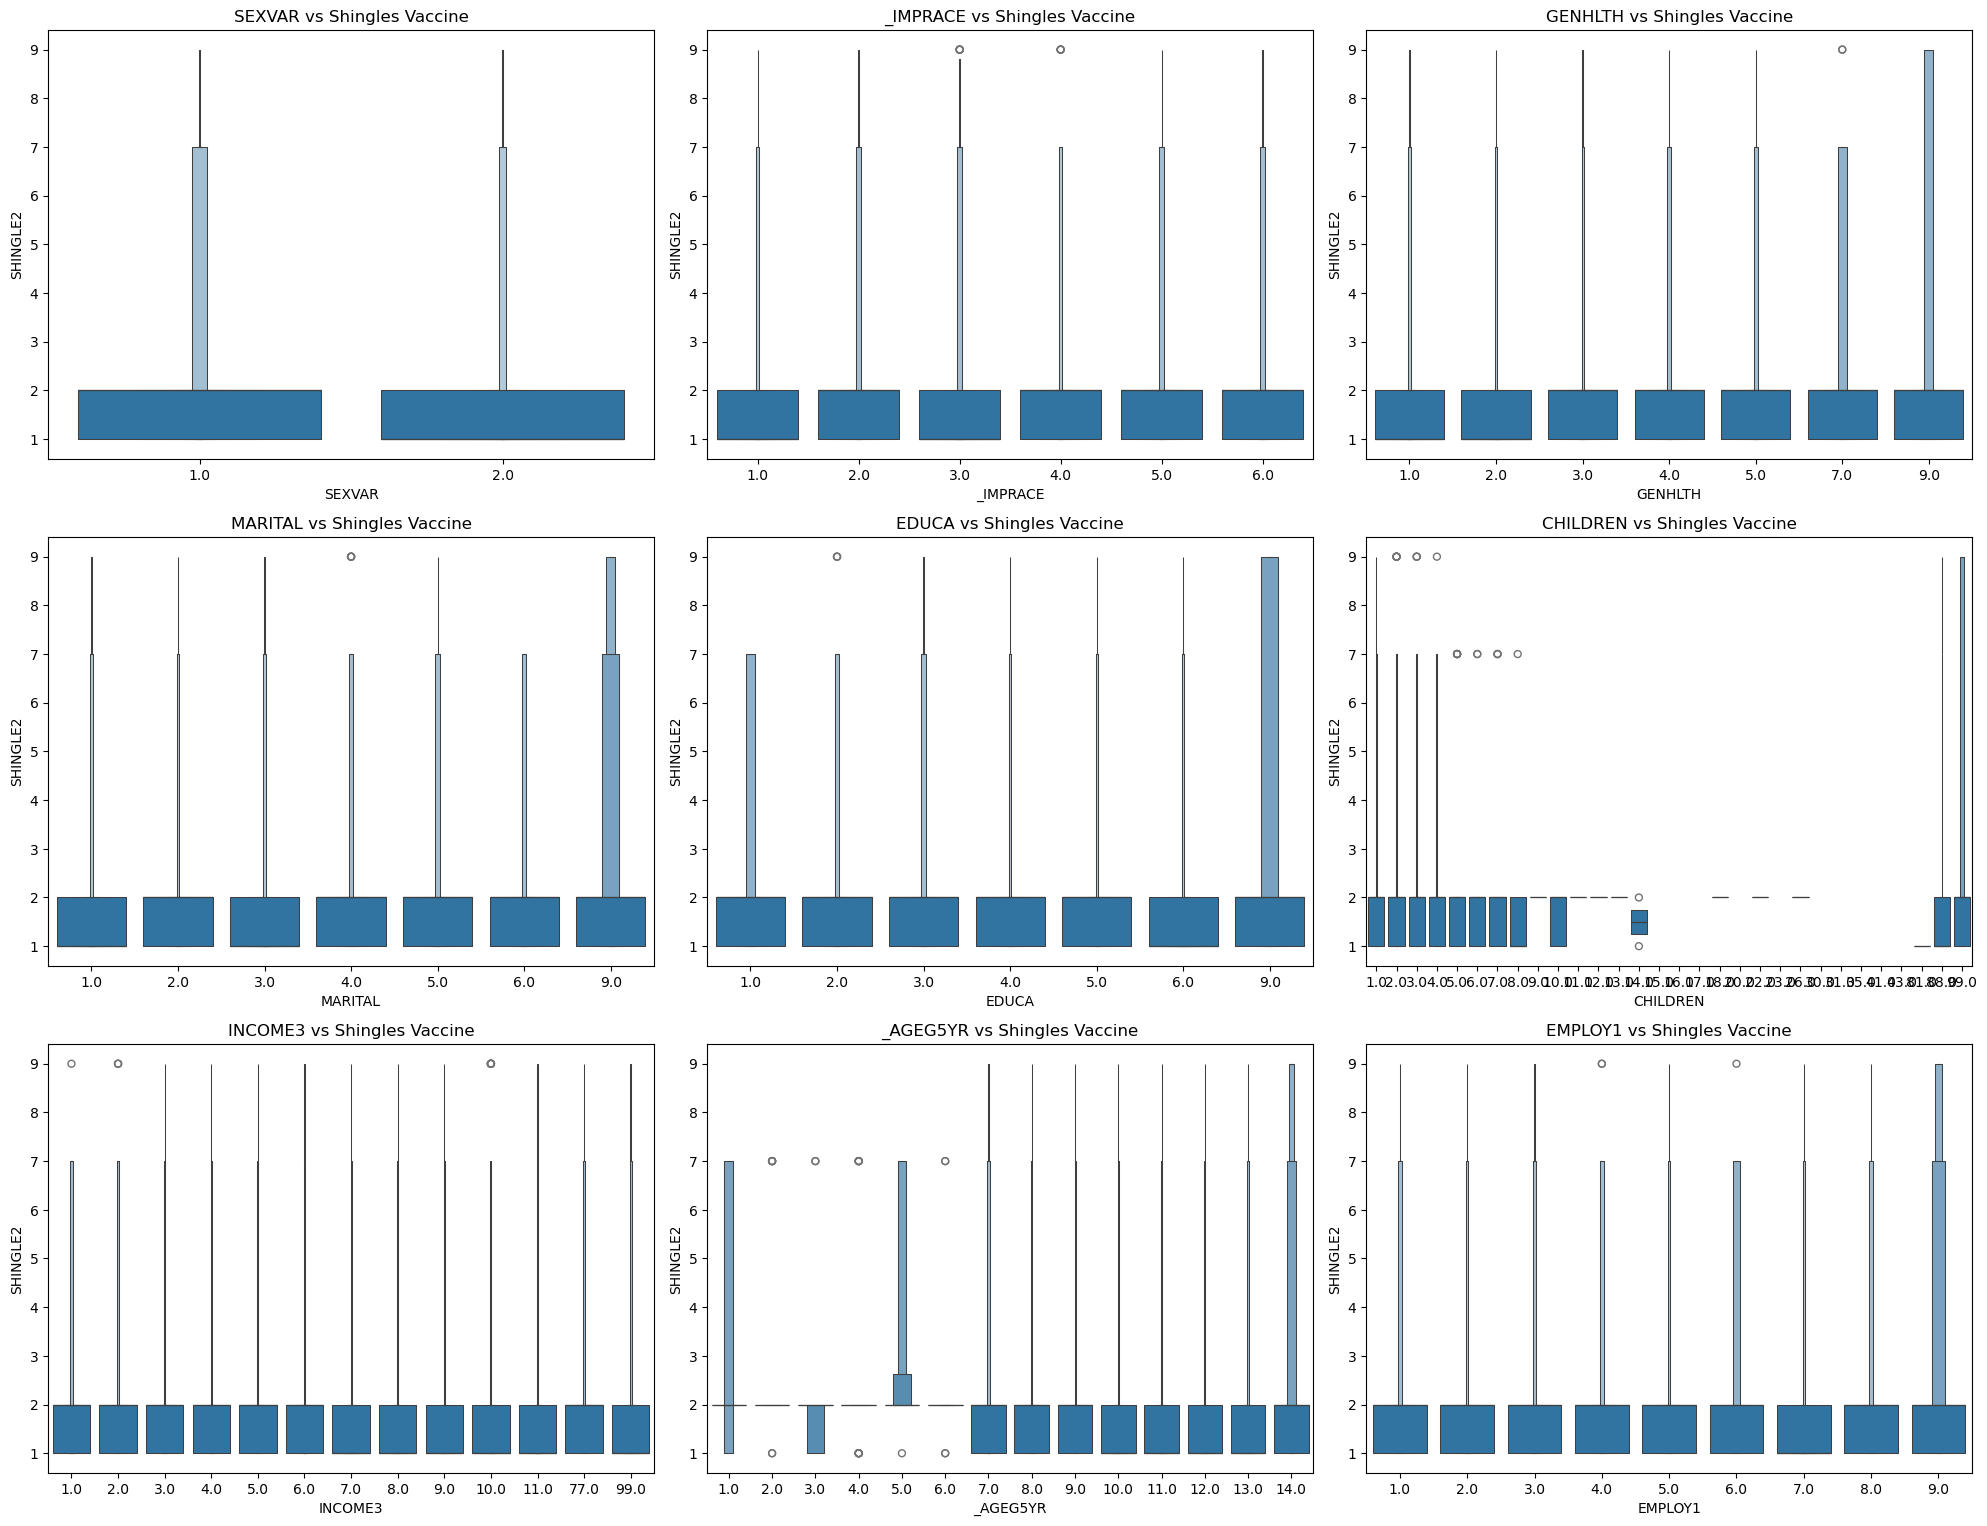

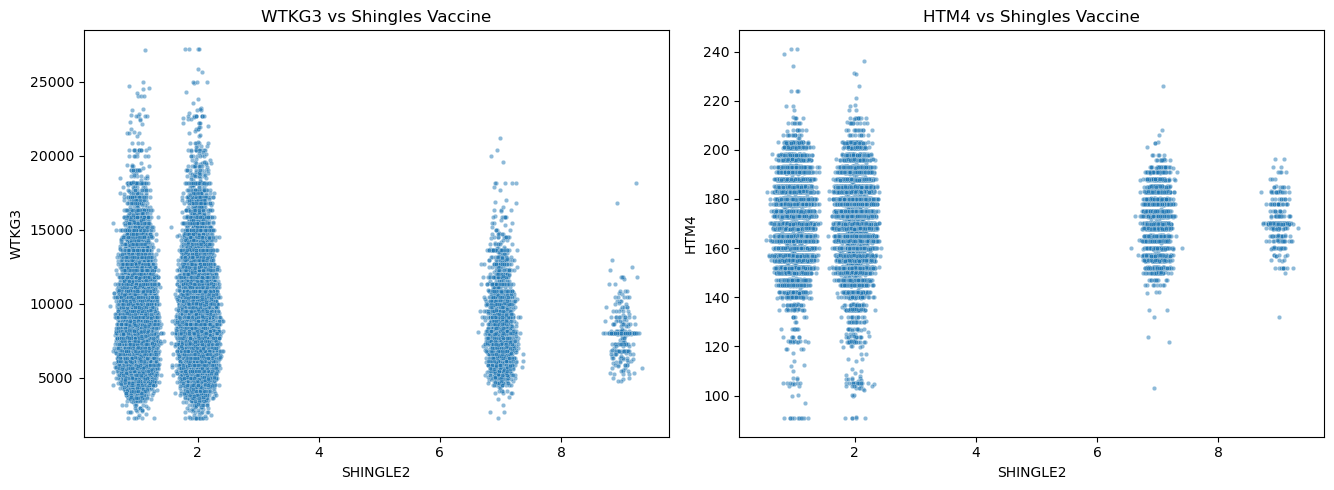

In [599]:
# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(possible_features_demographics_to_use) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(possible_features_demographics_to_use) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(possible_features_demographics_to_use):
    sns.boxenplot(x=cdc2023[col], y =cdc2023['SHINGLE2'], ax=axes[i])
    axes[i].set_title(f'{col} vs Shingles Vaccine')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(possible_features_demographics_to_use), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(demographic_continuous_features) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(demographic_continuous_features) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(demographic_continuous_features):
    x_jittered = cdc2023['SHINGLE2'] + np.random.normal(0, 0.1, size=len(cdc2023))
    y_jittered = cdc2023[col] + np.random.normal(0, 0.1, size=len(cdc2023))

    sns.scatterplot(x= x_jittered , y=y_jittered, ax=axes[i], alpha=0.5, s=10)
    axes[i].set_title(f'{col} vs Shingles Vaccine')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(demographic_continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [600]:
# From the plots above, it can be sex and general health are important factors for whether the individual got the vaccine or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['SHINGLE2'] = cdc2023.groupby(['SEXVAR', 'GENHLTH'])['SHINGLE2'].transform(lambda value: value.fillna(value.mode().iloc[0]))

cdc2023['SHINGLE2'].isnull().sum()

0

In [601]:
cdc2023['SHINGLE2'].value_counts()

SHINGLE2
1.000000    230916
2.000000    198764
7.000000      3305
9.000000       338
Name: count, dtype: int64

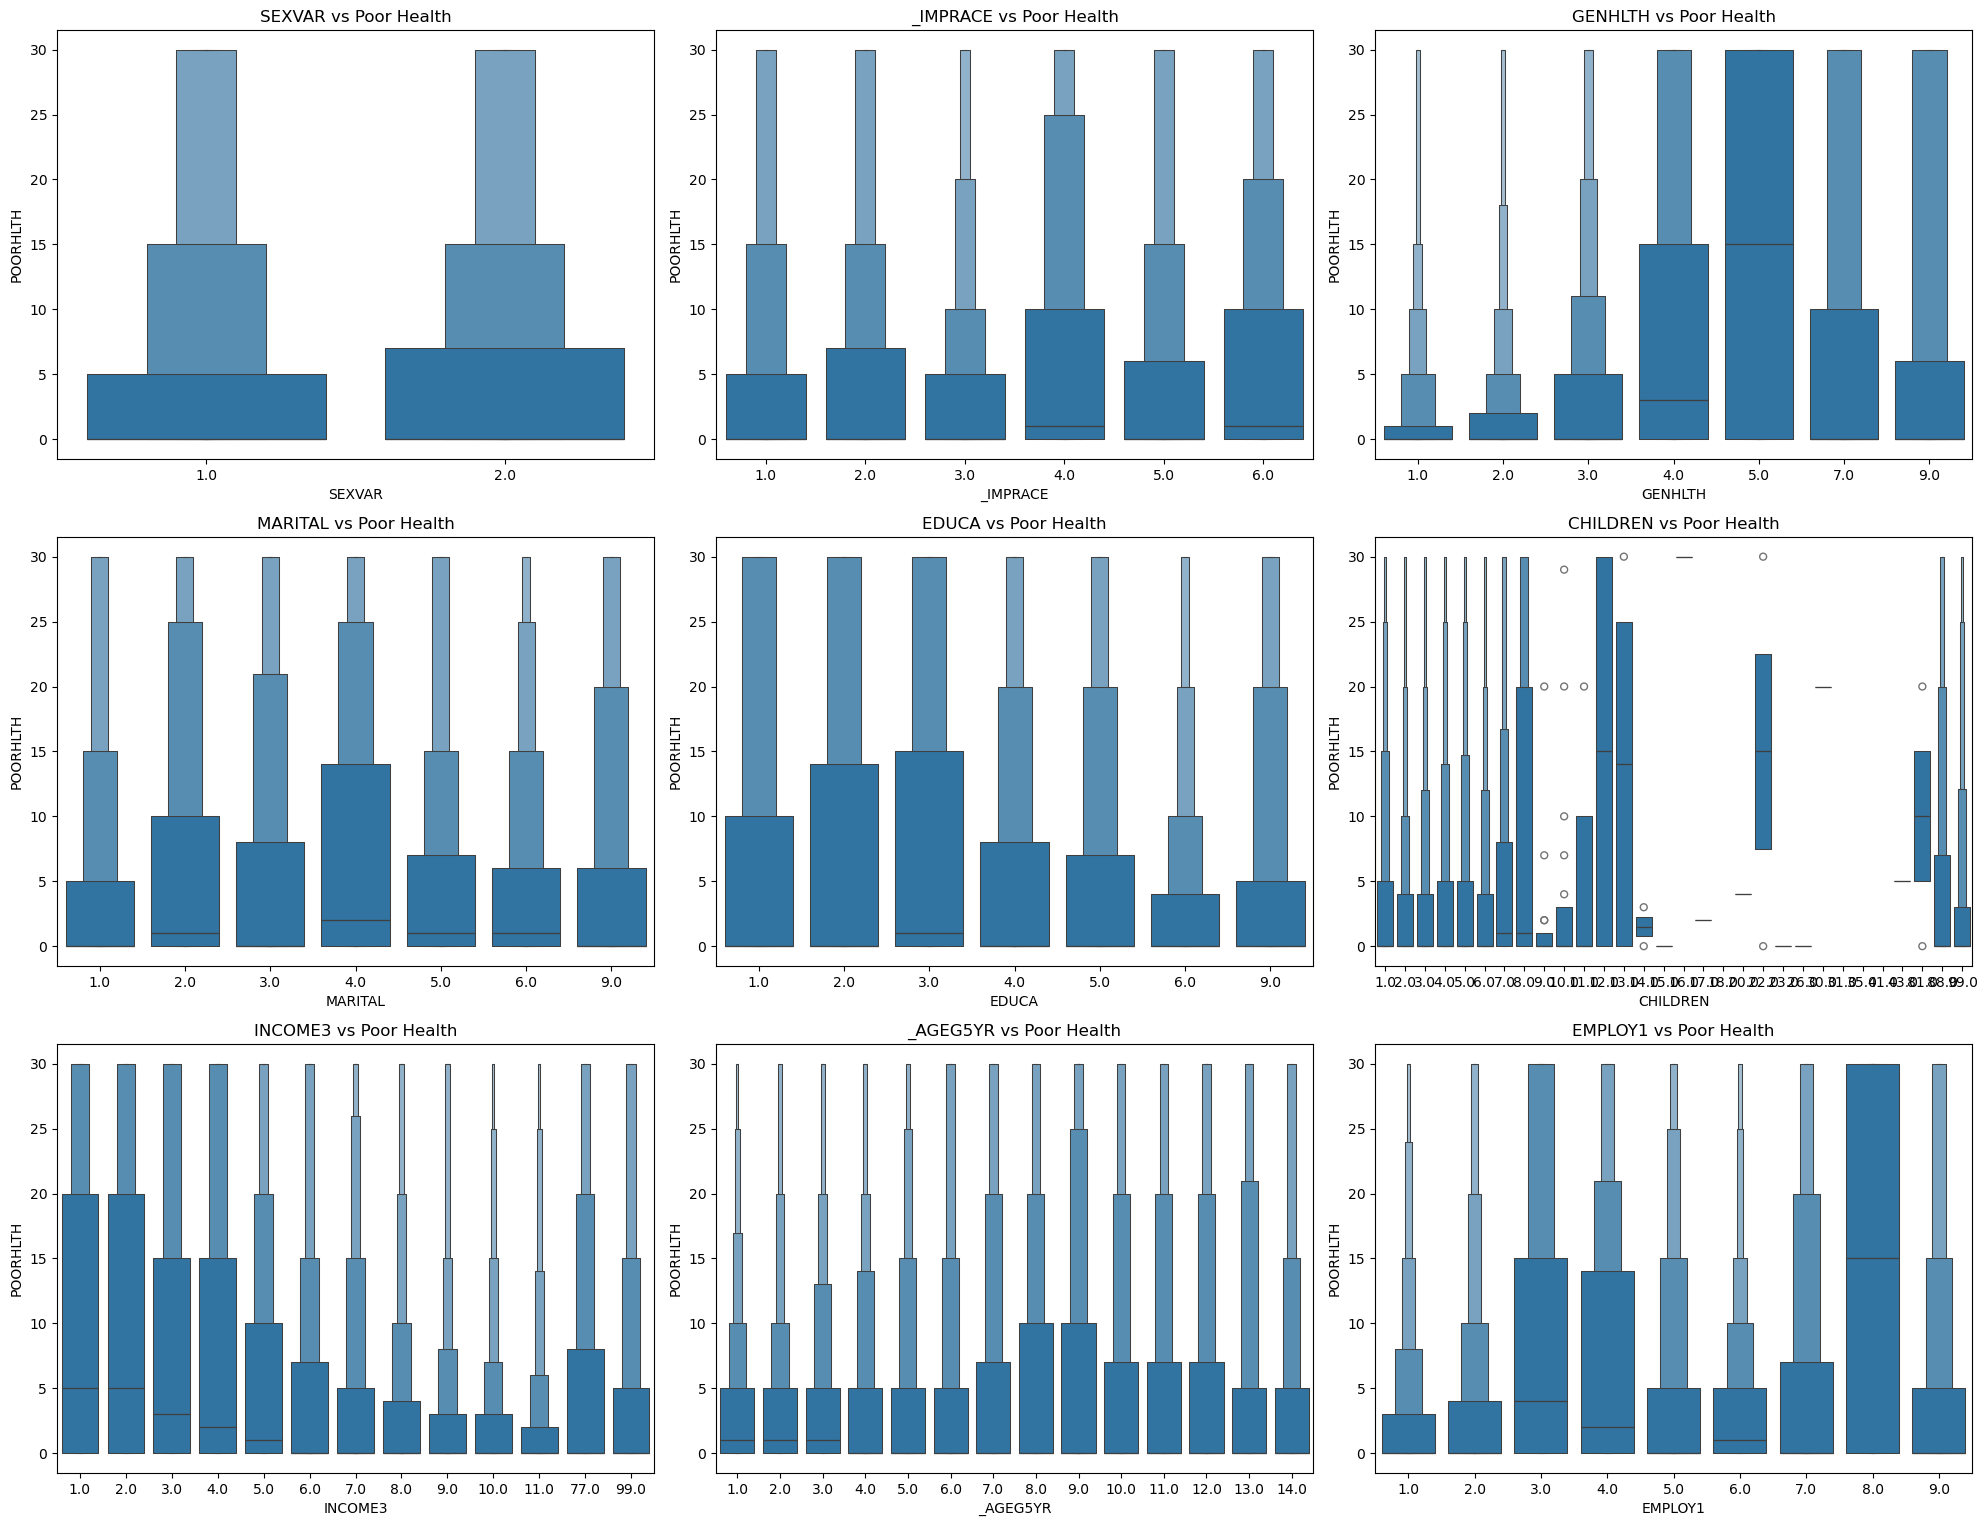

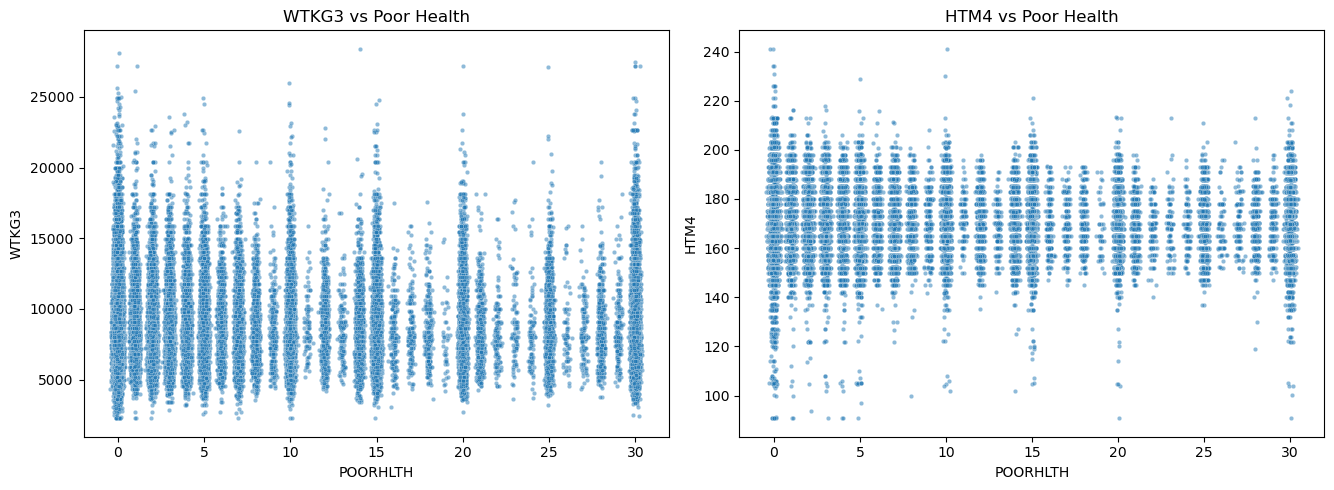

In [602]:
# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(possible_features_demographics_to_use) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(possible_features_demographics_to_use) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(possible_features_demographics_to_use):
    sns.boxenplot(x=cdc2023[col], y =cdc2023['POORHLTH'], ax=axes[i])
    axes[i].set_title(f'{col} vs Poor Health')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(possible_features_demographics_to_use), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(demographic_continuous_features) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(demographic_continuous_features) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(demographic_continuous_features):
    x_jittered = cdc2023['POORHLTH'] + np.random.normal(0, 0.1, size=len(cdc2023))
    y_jittered = cdc2023[col] + np.random.normal(0, 0.1, size=len(cdc2023))

    sns.scatterplot(x= x_jittered , y=y_jittered, ax=axes[i], alpha=0.5, s=10)
    axes[i].set_title(f'{col} vs Poor Health')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(demographic_continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [603]:
# From the plots above, it seems age and education are important factors for whether the individual has poor health or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['POORHLTH'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH', '_IMPRACE'])['POORHLTH'].transform(lambda value: value.fillna(value.median()))

cdc2023['POORHLTH'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['POORHLTH'].transform(lambda value: value.fillna(value.median()))

cdc2023['POORHLTH'].isnull().sum()

0

In [604]:
cdc2023['POORHLTH'].value_counts()

POORHLTH
0.000000     299812
30.000000     19534
2.000000      19016
1.000000      18013
5.000000      13546
3.000000      11627
15.000000      9820
10.000000      9697
7.000000       6527
4.000000       6460
20.000000      6128
14.000000      2707
25.000000      2194
6.000000       1969
8.000000       1459
12.000000       926
21.000000       636
28.000000       496
0.500000        420
9.000000        280
18.000000       241
16.000000       225
29.000000       183
17.000000       156
13.000000       153
22.000000       136
2.500000        128
27.000000       125
24.000000       101
11.000000        97
1.500000         93
23.000000        90
26.000000        79
3.500000         51
5.500000         49
19.000000        43
4.500000         35
6.500000         23
7.500000         18
17.500000        10
9.500000          4
12.500000         4
8.500000          3
27.500000         2
24.500000         2
20.500000         2
18.500000         2
22.500000         1
Name: count, dtype: int64

In [605]:
# majority of the values for this feature are 2. Hence, I will put any missing values in that category
cdc2023['HEATTBCO'].value_counts()

cdc2023['HEATTBCO'] = cdc2023['HEATTBCO'].fillna(2)

In [606]:
cdc2023['HEATTBCO'].value_counts()

HEATTBCO
2.000000    404585
1.000000     26928
7.000000      1326
9.000000       484
Name: count, dtype: int64

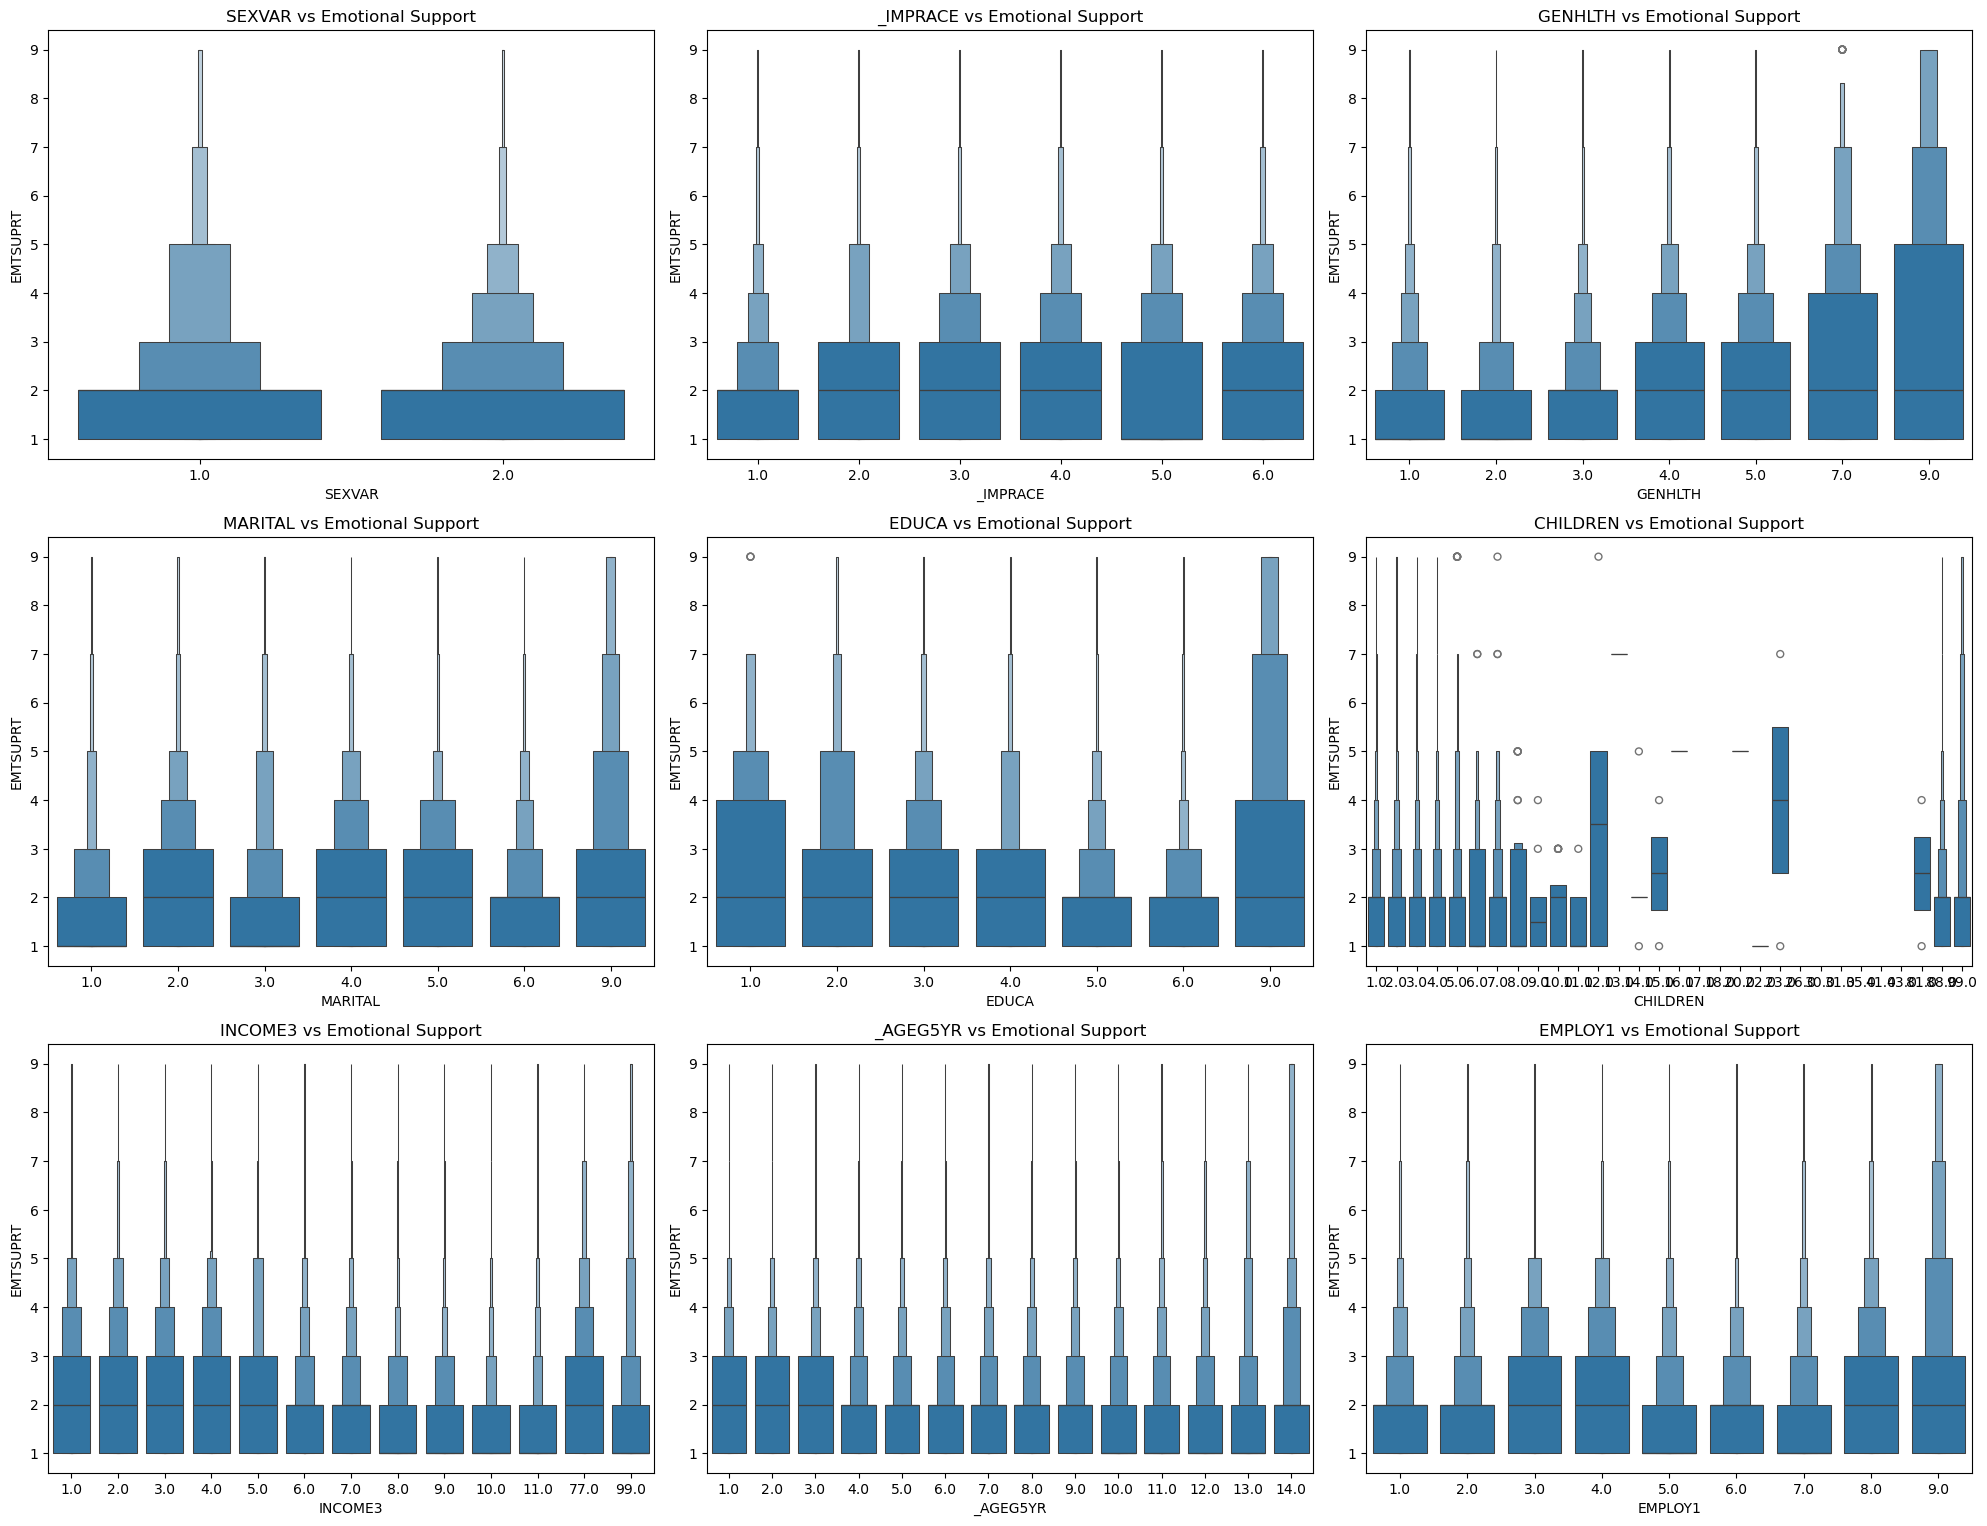

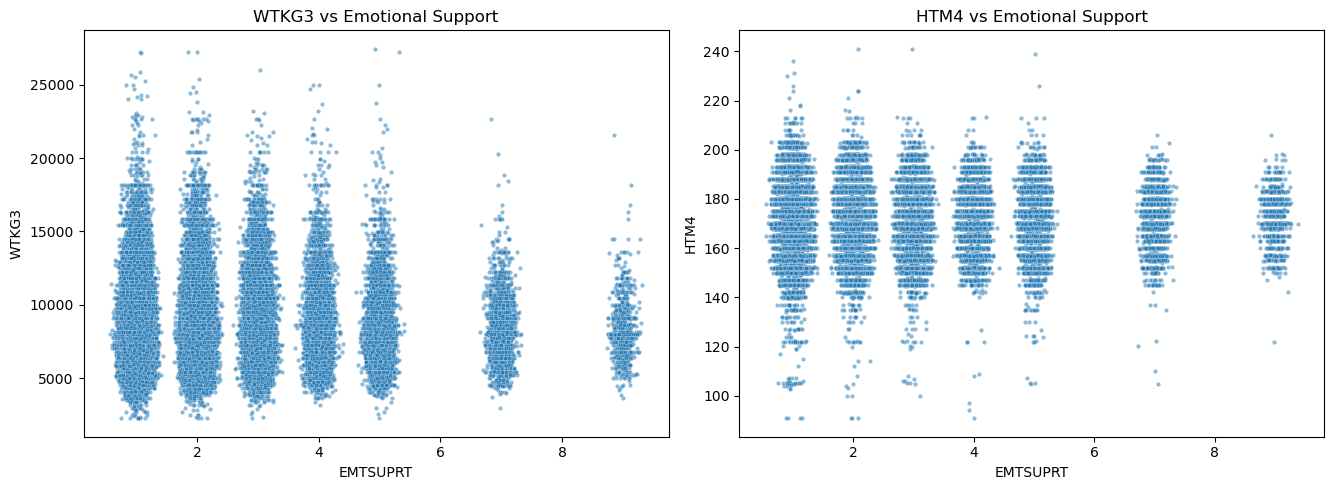

In [607]:
# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(possible_features_demographics_to_use) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(possible_features_demographics_to_use) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(possible_features_demographics_to_use):
    sns.boxenplot(x=cdc2023[col], y =cdc2023['EMTSUPRT'], ax=axes[i])
    axes[i].set_title(f'{col} vs Emotional Support')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(possible_features_demographics_to_use), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()



# Creating Subplots Grid
fig, axes = plt.subplots(nrows=(len(demographic_continuous_features) // 3) + 1, ncols=3, figsize=(20, 5 * ((len(demographic_continuous_features) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'SalePrice'
for i, col in enumerate(demographic_continuous_features):
    x_jittered = cdc2023['EMTSUPRT'] + np.random.normal(0, 0.1, size=len(cdc2023))
    y_jittered = cdc2023[col] + np.random.normal(0, 0.1, size=len(cdc2023))

    sns.scatterplot(x= x_jittered , y=y_jittered, ax=axes[i], alpha=0.5, s=10)
    axes[i].set_title(f'{col} vs Emotional Support')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(demographic_continuous_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [608]:
# From the plots above, it seems age and education are important factors for whether the individual has poor health or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['EMTSUPRT'] = cdc2023.groupby(['SEXVAR', 'EDUCA'])['EMTSUPRT'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# cdc2023['POORHLTH'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['POORHLTH'].transform(lambda value: value.fillna(value.median()))

cdc2023['EMTSUPRT'].isnull().sum()

0

In [609]:
cdc2023['EMTSUPRT'].value_counts()

EMTSUPRT
1.000000    317203
2.000000     67461
3.000000     28592
4.000000      8560
5.000000      8236
7.000000      2349
9.000000       922
Name: count, dtype: int64

In [610]:
cdc2023['SDHEMPLY'] = cdc2023['SDHEMPLY'].fillna(2)

cdc2023['SDHEMPLY'].value_counts()

SDHEMPLY
2.000000    411422
1.000000     19987
9.000000      1035
7.000000       879
Name: count, dtype: int64

In [611]:
cdc2023['FOODSTMP'] = cdc2023['FOODSTMP'].fillna(2)

cdc2023['FOODSTMP'].value_counts()

FOODSTMP
2.000000    410730
1.000000     21776
7.000000       450
9.000000       367
Name: count, dtype: int64

In [612]:
cdc2023['SDHFOOD1'] = cdc2023['SDHFOOD1'].fillna(5)

cdc2023['SDHFOOD1'].value_counts()

SDHFOOD1
5.000000    387221
4.000000     18575
3.000000     16720
1.000000      5190
2.000000      4306
7.000000       751
9.000000       560
Name: count, dtype: int64

In [615]:
# From the plots above, it seems age and education are important factors for whether the individual has poor health or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['ACTIN23_'] = cdc2023.groupby(['SEXVAR', 'GENHLTH'])['ACTIN23_'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# cdc2023['POORHLTH'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['POORHLTH'].transform(lambda value: value.fillna(value.median()))

cdc2023['ACTIN23_'].isnull().sum()

0

In [616]:
cdc2023['ACTIN23_'].value_counts()

ACTIN23_
1.000000    323274
2.000000     80117
0.000000     29932
Name: count, dtype: int64

In [ ]:
# From the plots above, it seems age and education are important factors for whether the individual has poor health or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['SDHSTRE1'] = cdc2023.groupby(['SEXVAR', 'GENHLTH'])['SDHSTRE1'].transform(lambda value: value.fillna(value.median()))

cdc2023['SDHSTRE1'].isnull().sum()

0

In [619]:
cdc2023['SDHSTRE1'].value_counts()

SDHSTRE1
4.000000    229319
5.000000    100827
3.000000     75875
2.000000     15120
1.000000     10921
7.000000       718
9.000000       543
Name: count, dtype: int64

In [622]:
# From the plots above, it seems age and education are important factors for whether the individual has poor health or not.
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['COVIDSM1'] = cdc2023.groupby(['SEXVAR', 'GENHLTH'])['COVIDSM1'].transform(lambda value: value.fillna(value.median()))

cdc2023['COVIDSM1'].isnull().sum()

0

In [623]:
cdc2023['COVIDSM1'].value_counts()

COVIDSM1
2.000000    403199
1.000000     27074
7.000000      2924
9.000000       126
Name: count, dtype: int64

In [626]:
# Hence, we would group by the sex and general health of the individual to fill for the mode based on that feature
cdc2023['BPMEDS1'] = cdc2023.groupby(['SEXVAR', 'GENHLTH'])['BPMEDS1'].transform(lambda value: value.fillna(value.median()))
                                                                                   
cdc2023['BPMEDS1'].isnull().sum()

0

In [627]:
cdc2023['BPMEDS1'].value_counts()

BPMEDS1
1.000000    401190
2.000000     31631
7.000000       344
9.000000       158
Name: count, dtype: int64

In [653]:
#Creat a new variable as target, 
# Create a new variable based on diabetes4
cdc2023['new_diabetes4'] = cdc2023['DIABETE4'].copy()

# For rows where prediabetes_or_borderline_diabetes is 1, update the new variable to 4
cdc2023.loc[cdc2023['PREDIAB2'] == 1, 'new_diabetes4'] = 4

# Check the value counts to ensure there are 23945 instances of 4
print(cdc2023['new_diabetes4'].value_counts())

cdc2023.drop(columns=['PREDIAB2'], axis=1, inplace=True)

new_diabetes4
3.000000    340022
1.000000     59786
4.000000     29643
2.000000      2991
7.000000       589
9.000000       287
Name: count, dtype: int64
